In [ ]:
from langchain_community.document_loaders import PyPDFLoader

# Paso 1: Definir la ruta del archivo PDF

# Ruta del archivo PDF (asegúrate de que el archivo esté en la misma carpeta o usa una ruta completa)
ruta_pdf = "../data/biblioteca-de-alimentos.pdf"

In [4]:
# Paso 2: Cargar el archivo PDF con PyPDFLoader
loader = PyPDFLoader(ruta_pdf)

In [5]:
# Extraer las páginas del PDF
documento = loader.load()

In [7]:
# Concatenar el texto de todas las páginas en un solo string
texto_pdf = "\n".join([page.page_content for page in documento])

In [10]:
#Paso 3: Exportar el texto extraído a un archivo .txt
ruta_txt = "archivo_extraido.txt"
with open(ruta_txt, "w", encoding="utf-8") as archivo_txt:
    archivo_txt.write(texto_pdf)

In [11]:
# Confirmación
print(f"El texto extraído del PDF se ha guardado en el archivo: {ruta_txt}")

El texto extraído del PDF se ha guardado en el archivo: archivo_extraido.txt


## Recursive Character Splitter

In [12]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [19]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 215, chunk_overlap=0)

In [20]:
text_splitter.create_documents([texto_pdf])

[Document(metadata={}, page_content='BIBLIOTECA DE \nALIMENTOS \nAtualizada em 06.11.2024 \nCoordenação de Processos Regulatórios – CPROR \nAssessoria de Melhoria da Qualidade Regulatória – ASREG \nGabinete do Diretor-Presidente'),
 Document(metadata={}, page_content='AGENDA REGULATÓRIA \nCiclo Bienal \n2024-2025 \n \n \nAPRESENTAÇÃO \n \n As Bibliotecas são documentos que reúnem todas as normas vigentes de determinado'),
 Document(metadata={}, page_content='macrotema, divididos por temas. O objetivo é facilitar o acesso e a compreensão do Estoque \nRegulatório ao público interno e externo, bem como aprimorar o processo de elaboração e \nrevisão das normativas.'),
 Document(metadata={}, page_content='Não deixe de consultar também a Biblioteca de Temas Transversais, que abrange assuntos \naplicados a todos os macrotemas, tais como: Autorização de Funcionamento de Empresa'),
 Document(metadata={}, page_content='(AFE), Certificação de Boas Práticas de Fabricação (CBPF), Taxas de Fiscaliza

## Guardado de los Chunks

In [21]:
import os

# Create the new folder if it doesn't exist
os.makedirs("Chunks_1", exist_ok=True)

# Split the text into chunks
chunks = text_splitter.split_text(texto_pdf)

# Save each chunk into an individual .txt file
for i, chunk in enumerate(chunks):
    chunk_filename = f"Chunks_1/chunk_{i+1}.txt"
    with open(chunk_filename, "w", encoding="utf-8") as chunk_file:
        chunk_file.write(chunk)

print(f"Saved {len(chunks)} chunks into the 'Chunks_1' folder.")

Saved 318 chunks into the 'Chunks_1' folder.


## Semantic Chunking

### División de texto en oraciones

In [22]:
import re

# Splitting the essay on '.', '?', and '!'
single_sentences_list = re.split(r'(?<=[.?!])\s+', texto_pdf)
print (f"{len(single_sentences_list)} sentences were found")

490 sentences were found


In [25]:
sentences = [{'sentence': x, 'index' : i} for i, x in enumerate(single_sentences_list)]
#sentences[:10]

In [26]:
def combine_sentences(sentences, buffer_size=1):
    # Go through each sentence dict
    for i in range(len(sentences)):

        # Create a string that will hold the sentences which are joined
        combined_sentence = ''

        # Add sentences before the current one, based on the buffer size.
        for j in range(i - buffer_size, i):
            # Check if the index j is not negative (to avoid index out of range like on the first one)
            if j >= 0:
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += sentences[j]['sentence'] + ' '

        # Add the current sentence
        combined_sentence += sentences[i]['sentence']

        # Add sentences after the current one, based on the buffer size
        for j in range(i + 1, i + 1 + buffer_size):
            # Check if the index j is within the range of the sentences list
            if j < len(sentences):
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += ' ' + sentences[j]['sentence']

        # Then add the whole thing to your dict
        # Store the combined sentence in the current sentence dict
        sentences[i]['combined_sentence'] = combined_sentence

    return sentences

sentences = combine_sentences(sentences)

In [27]:
from langchain.embeddings import OpenAIEmbeddings
oaiembeds = OpenAIEmbeddings()

C:\Users\nicol\AppData\Local\Temp\ipykernel_29440\662863333.py:2: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  oaiembeds = OpenAIEmbeddings()


In [28]:
embeddings = oaiembeds.embed_documents([x['combined_sentence'] for x in sentences])

In [29]:
for i, sentence in enumerate(sentences):
    sentence['combined_sentence_embedding'] = embeddings[i]

In [30]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_distances(sentences):
    distances = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]['combined_sentence_embedding']
        embedding_next = sentences[i + 1]['combined_sentence_embedding']
        
        # Calculate cosine similarity
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]
        
        # Convert to cosine distance
        distance = 1 - similarity

        # Append cosine distance to the list
        distances.append(distance)

        # Store distance in the dictionary
        sentences[i]['distance_to_next'] = distance

    # Optionally handle the last sentence
    # sentences[-1]['distance_to_next'] = None  # or a default value

    return distances, sentences

In [32]:
distances, sentences = calculate_cosine_distances(sentences)

In [ ]:
#distances[:3]

[0.010384104964105356, 0.09201073594584519, 0.032113094316291724]

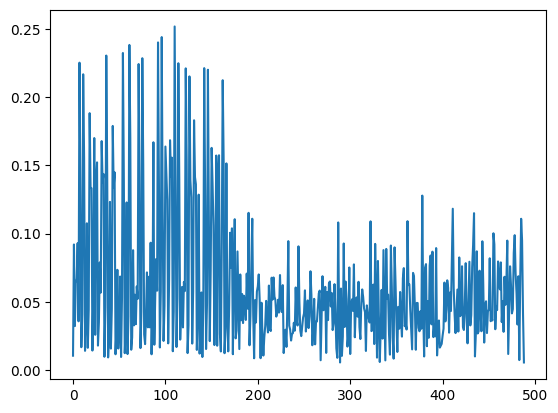

In [34]:
import matplotlib.pyplot as plt

plt.plot(distances);

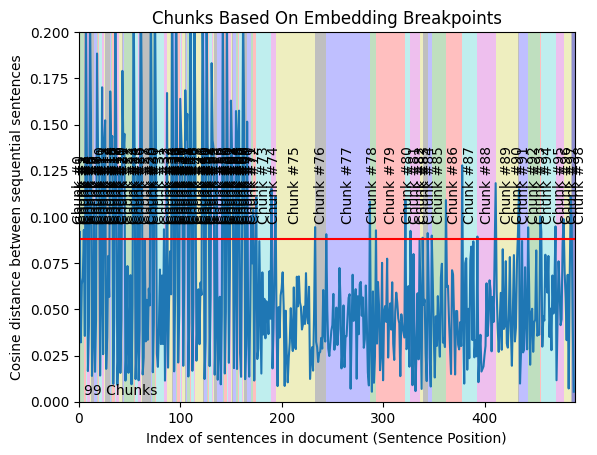

In [45]:
import numpy as np

plt.plot(distances);

y_upper_bound = .2
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))

# We need to get the distance threshold that we'll consider an outlier
# We'll use numpy .percentile() for this
breakpoint_percentile_threshold = 80
breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold) # If you want more chunks, lower the percentile cutoff
plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-');

# Then we'll see how many distances are actually above this one
num_distances_above_theshold = len([x for x in distances if x > breakpoint_distance_threshold]) # The amount of distances above your threshold
plt.text(x=(len(distances)*.01), y=y_upper_bound/50, s=f"{num_distances_above_theshold + 1} Chunks");

# Then we'll get the index of the distances that are above the threshold. This will tell us where we should split our text
indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of those breakpoints on your list

# Start of the shading and text
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, breakpoint_index in enumerate(indices_above_thresh):
    start_index = 0 if i == 0 else indices_above_thresh[i - 1]
    end_index = breakpoint_index if i < len(indices_above_thresh) - 1 else len(distances)

    plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
    plt.text(x=np.average([start_index, end_index]),
             y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
             s=f"Chunk #{i}", horizontalalignment='center',
             rotation='vertical')

# # Additional step to shade from the last breakpoint to the end of the dataset
if indices_above_thresh:
    last_breakpoint = indices_above_thresh[-1]
    if last_breakpoint < len(distances):
        plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(indices_above_thresh) % len(colors)], alpha=0.25)
        plt.text(x=np.average([last_breakpoint, len(distances)]),
                 y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                 s=f"Chunk #{i+1}",
                 rotation='vertical')

plt.title("Chunks Based On Embedding Breakpoints")
plt.xlabel("Index of sentences in document (Sentence Position)")
plt.ylabel("Cosine distance between sequential sentences")
plt.show()

In [38]:
# Initialize the start index
start_index = 0

# Create a list to hold the grouped sentences
chunks = []

# Iterate through the breakpoints to slice the sentences
for index in indices_above_thresh:
    # The end index is the current breakpoint
    end_index = index

    # Slice the sentence_dicts from the current start index to the end index
    group = sentences[start_index:end_index + 1]
    combined_text = ' '.join([d['sentence'] for d in group])
    chunks.append(combined_text)
    
    # Update the start index for the next group
    start_index = index + 1

# The last group, if any sentences remain
if start_index < len(sentences):
    combined_text = ' '.join([d['sentence'] for d in sentences[start_index:]])
    chunks.append(combined_text)

# grouped_sentences now contains the chunked sentences

In [43]:
for i, chunk in enumerate(chunks[:100]):
    buffer = 200
    
    print (f"Chunk #{i}")
    print (chunk[:buffer].strip())
    print ("...")
    print (chunk[-buffer:].strip())
    print ("\n")

Chunk #0
BIBLIOTECA DE 
ALIMENTOS 
Atualizada em 06.11.2024 
Coordenação de Processos Regulatórios – CPROR 
Assessoria de Melhoria da Qualidade Regulatória – ASREG 
Gabinete do Diretor-Presidente
...
otema, divididos por temas. O objetivo é facilitar o acesso e a compreensão do Estoque 
Regulatório ao público interno e externo, bem como aprimorar o processo de elaboração e 
revisão das normativas.


Chunk #1
Não deixe de consultar também a Biblioteca de Temas Transversais, que abrange assuntos 
aplicados a todos os macrotemas, tais como: Autorização de Funcionamento de Empresa 
(AFE), Certificação de Boas
...
coadjuvantes de tecnologia, materiais em contato 
com alimentos, contaminantes, resíduos de medicamentos veterinários, rotulagem e inovações 
tecnológicas em produtos da área de alimentos. Sumário 
1.


Chunk #2
Regularização, avaliação de risco e padrões de alimentos ................................ ................................
...
Regularização, avaliação de risco e padrões 